In [25]:
# Imports
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import warnings

from joblib import dump

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble      import RandomForestRegressor, GradientBoostingClassifier
from src.tools             import ml_error
from src.tools             import timeSeries_CV
from scipy.stats import randint
warnings.filterwarnings( 'ignore' )
from src.tools import jupyter_settings

In [2]:
jupyter_settings()

In [3]:
X = pd.read_csv('data/X.csv')
y  = pd.read_csv('data/y.csv')

### 8. Hyperparameter Fine tuning with Bayesian Search

In [9]:
from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import xgboost as xgb
import pandas as pd

#dados

X = pd.read_csv('data/X.csv')
y  = pd.read_csv('data/y.csv')

#model

xgb_bay = xgb.XGBRegressor()

# Bayesian
n_iter = 5

# Criar objeto TimeSeriesSplit para validação cruzada
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'max_depth': [ 6, 10], 
            'learning_rate': [0.01, 0.1, 0.2, 0.3], 
            'subsample': np.arange(0.5, 1.0, 0.1), 
            'colsample_bytree': np.arange(0.4, 1.0, 0.1), 
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1), 
            'n_estimators': [100, 500, 1000]}


reg_bay = BayesSearchCV(estimator= xgb_bay,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=tscv,
                    n_jobs=8,
                    scoring= 'neg_mean_squared_error',
                    random_state=123, verbose= 5)

model_bay = reg_bay.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [11]:
model = model_bay.best_estimator_

In [16]:
model_bay.best_params_

OrderedDict([('colsample_bylevel', 0.7),
             ('colsample_bytree', 0.6),
             ('learning_rate', 0.1),
             ('max_depth', 9),
             ('n_estimators', 500),
             ('subsample', 0.6)])

In [13]:

from src.tools import timeSeries_CV
model_bay_result = timeSeries_CV(X, y, model_name= 'result', model= model, kfold= 5)

In [15]:
model_bay_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,result,932.25 +/- 194.6,0.14 +/- 0.02,1353.64 +/- 304.54


### 8.2. Final Model

In [1]:

import pandas as pd
import xgboost as xgb
from src.tools import ml_error, mean_percentage_erro, jupyter_settings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
#dataset

X_train  = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

X_train = X_train.drop(['date', 'sales'], axis= 1)
X_test = X_test.drop(['date', 'sales'], axis= 1)

In [4]:
cols_select = ['store',
                'promo',
                'store_type',
                'competition_distance',
                'competition_open_since_month',
                'competition_open_since_year',
                'promo2_since_week',
                'competition_time_month',
                'promo_time_week',
                'day_of_week_sin',
                'day_of_week_cos',
                'month_cos',
                'month_sin',
                'day_sin',
                'day_cos']

In [5]:
param = {
'colsample_bylevel': 0.7,
'colsample_bytree': 0.6,
'learning_rate': 0.1,
'max_depth': 9,
'n_estimators': 500,
'subsample': 0.6}

In [6]:
# Model

model_XGB_Tuned = xgb.XGBRegressor(colsample_bylevel = param['colsample_bylevel'],
                                    colsample_bytree = param['colsample_bytree'],
                                    learning_rate = param['learning_rate'],
                                    max_depth = param['max_depth'],
                                    n_estimators = param['n_estimators'],
                                    subsample = param['subsample']
                                                        ).fit(X_train[cols_select], y_train)



In [8]:
# prediction 
yhat_xgb_tuned = model_XGB_Tuned.predict(X_test[cols_select])

#performance FINAL

xgb_bay_tuned_result = ml_error('Random Forest regression Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_bay_tuned_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest regression Tuned,690.592889,0.101604,997.192558


In [9]:
# Salvar o modelo

pickle.dump(model_XGB_Tuned, file =  open('C:/Users/55329/Documents/3.Repos/Rossmann-sales/model/model_xgb_tuned.pkl', 'wb'))

In [10]:
# Verificar se o modelo esta Superestimando ou Subestimando

mean_percentage_erro(np.expm1(list(y_test['sales'])), np.expm1(yhat_xgb_tuned))


-0.010312936926417339

## 9. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [8]:
df9 = pd.read_csv('data/X_test.csv')

#Rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1 Bussines Performance

In [18]:
# sum of predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import sklearn.metrics            

df91 = df9[['store', 'predictions']].groupby( 'store' ).agg(['sum','mean']).reset_index()
df91.columns = df91.columns.get_level_values(1)
df91.rename(columns={'':'store','sum' : 'total_prediction','mean': 'mean_prediction'},inplace= True)

#MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'})

#merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )



# Scenarios

df92['worst_scenario_total'] = df92['total_prediction'] - df92['MAE']*42
df92['best_scenario_total'] = df92['total_prediction'] + df92['MAE']*42

df92['worst_scenario_mean'] = df92['mean_prediction'] - df92['MAE']
df92['best_scenario_mean'] = df92['mean_prediction'] + df92['MAE']

df92['absolute_error'] = df92['MAE']*42
#order columns

# Visão total
df93 = df92[['store', 'total_prediction', 'worst_scenario_total', 'best_scenario_total', 'absolute_error' ,'MAPE']]

#visão diaria

df94 = df92[['store','mean_prediction', 'worst_scenario_mean', 'best_scenario_mean','MAE', 'MAPE']]


In [19]:
df93

,store,total_prediction,worst_scenario_total,best_scenario_total,absolute_error,MAPE
0,1,167726.812500,154674.370803,180779.254197,13052.441697,0.072977
1,2,177246.406250,161643.266298,192849.546202,15603.139952,0.075920
2,3,262017.046875,238156.585317,285877.508433,23860.461558,0.078460
3,4,332381.156250,286122.527740,378639.784760,46258.628510,0.107357
4,5,174129.265625,156900.840794,191357.690456,17228.424831,0.091558
...,...,...,...,...,...,...
1110,1111,171411.000000,146393.002402,196428.997598,25017.997598,0.121229
1111,1112,335588.156250,294189.551177,376986.761323,41398.605073,0.123908
1112,1113,236590.734375,215795.385162,257386.083588,20795.349213,0.075705
1113,1114,758585.312500,648546.519690,868624.105310,110038.792810,0.111701


In [20]:
df94

,store,mean_prediction,worst_scenario_mean,best_scenario_mean,MAE,MAPE
0,1,4533.157227,4222.384805,4843.929648,310.772421,0.072977
1,2,4790.443359,4418.940027,5161.946692,371.503332,0.075920
2,3,7081.541992,6513.435765,7649.648220,568.106228,0.078460
3,4,8983.274414,7881.878497,10084.670331,1101.395917,0.107357
4,5,4706.196289,4295.995698,5116.396880,410.200591,0.091558
...,...,...,...,...,...,...
1110,1111,4632.729492,4037.062883,5228.396102,595.666609,0.121229
1111,1112,9069.950195,8084.269122,10055.631268,985.681073,0.123908
1112,1113,6394.344238,5899.216876,6889.471601,495.127362,0.075705
1113,1114,20502.306641,17882.335383,23122.277898,2619.971257,0.111701


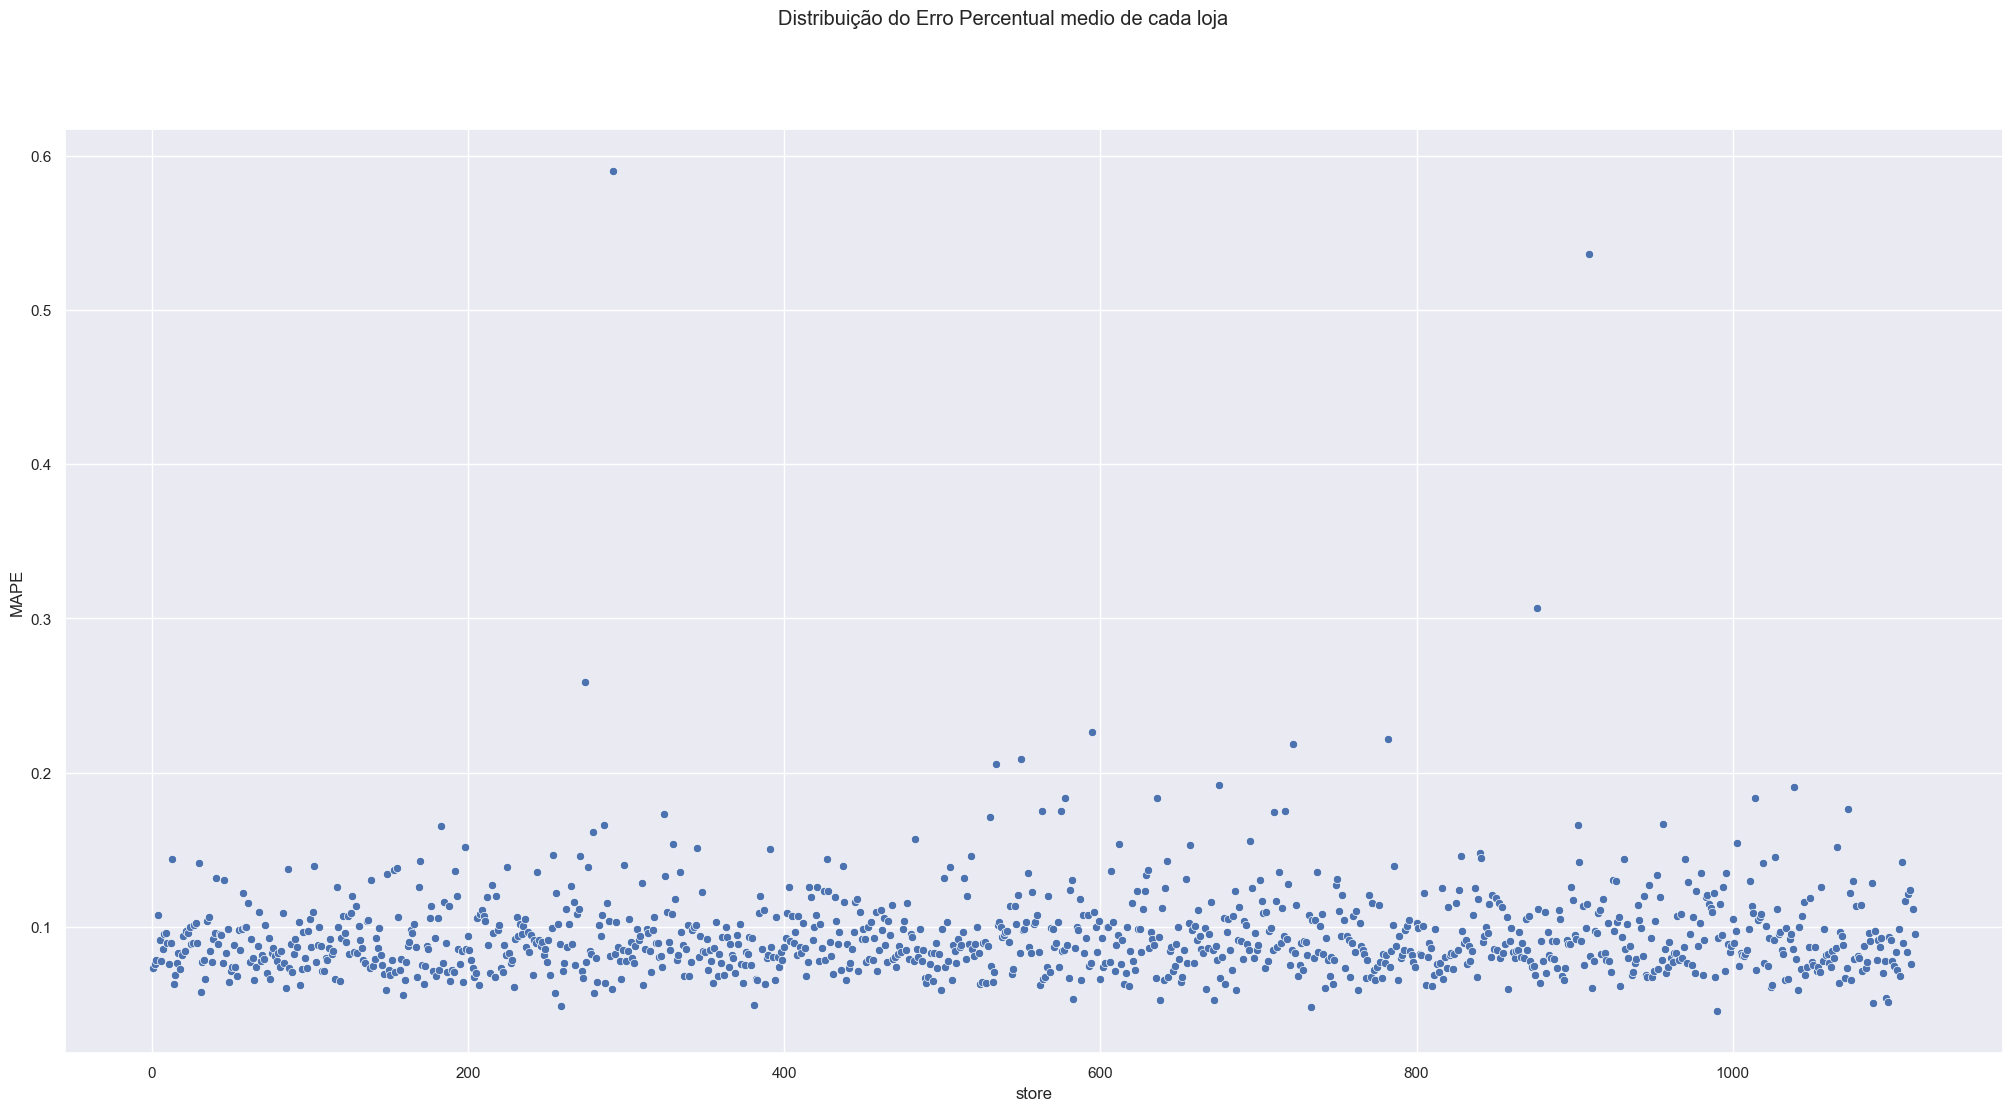

In [37]:
jupyter_settings()
fig = plt.figure()
fig.suptitle('Distribuição do Erro Percentual medio de cada loja')
ax = sns.scatterplot( x='store', y='MAPE', data=df92)
plt.show()

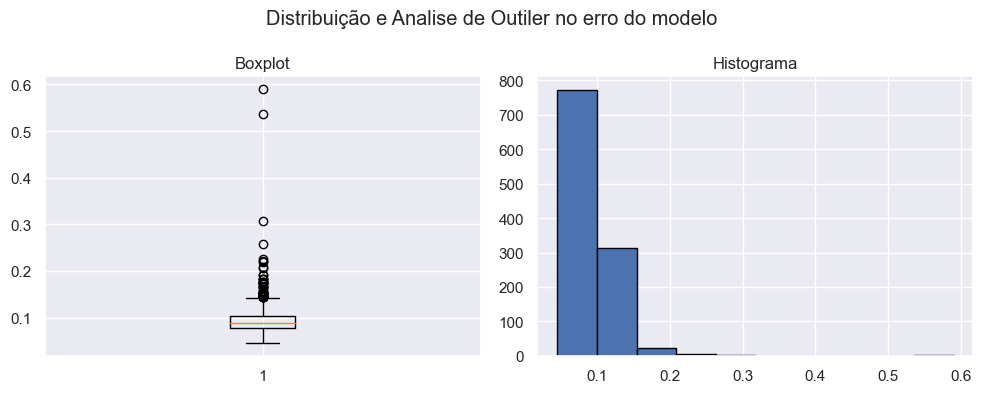

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#Titulo
fig.suptitle('Distribuição e Analise de Outiler no erro do modelo')

# Boxplot
axes[0].boxplot(df92['MAPE'])
axes[0].set_title('Boxplot')
# Histograma
axes[1].hist(df92['MAPE'], bins=10, edgecolor='black')
axes[1].set_title('Histograma')

plt.tight_layout()
plt.show()

### 9.2 Total Performance

In [109]:
df95 = df92[['total_prediction', 'worst_scenario_total', 'best_scenario_total']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df95['Values'] = df95['Values'].map( 'R${:,.2f}'.format )
df95

,Scenario,Values
0,total_prediction,"R$289,766,398.55"
1,worst_scenario_total,"R$258,365,744.30"
2,best_scenario_total,"R$321,167,052.81"


### 9.3 Machine Learning Performance

<Axes: xlabel='predictions', ylabel='error'>

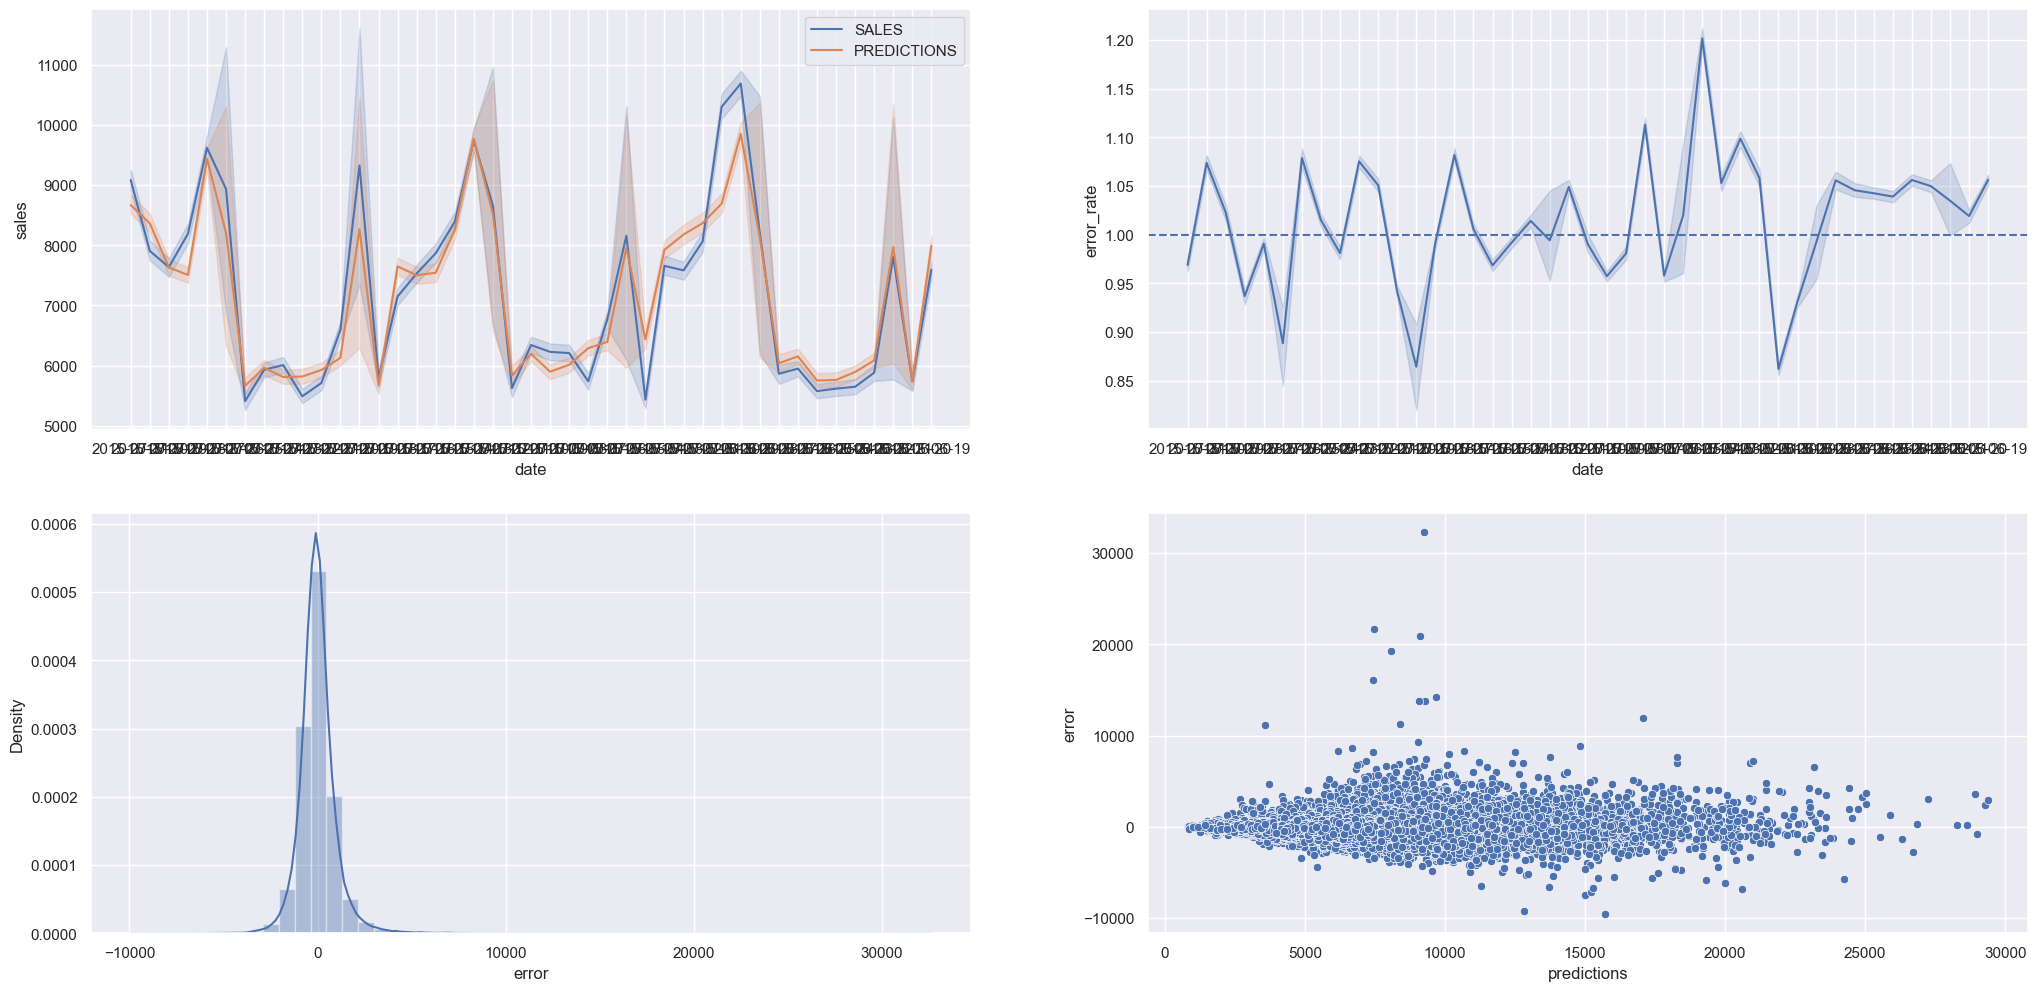

In [117]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot(x =  df9['predictions'], y = df9['error'] )
